In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import entropy
import gget

# locals
import utils as ut

# Load GTF

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/single_cell_fibroblast/references/geneTable.csv"

columns = [
    'Feature', 
    'gene_id',
    'gene_name', 
    'gene_biotype', 
    'transcript_id',
    'transcript_name',
    'transcript_biotype',
]

gdf = pd.read_csv(fpath, usecols=columns)
gdf = gdf[gdf['Feature'] == 'transcript']
gdf = gdf.drop_duplicates()
print(f"{gdf.shape=}")
gdf.head()

gdf.shape=(251121, 7)


,Feature,gene_id,gene_name,gene_biotype,transcript_id,transcript_name,transcript_biotype
1,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000673477,ATAD3B-206,protein_coding
38,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000472194,ATAD3B-203,retained_intron
53,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000378736,ATAD3B-202,processed_transcript
58,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000485748,ATAD3B-205,retained_intron
69,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000474481,ATAD3B-204,retained_intron


# Load uniprot mapping

In [3]:
fpath =  "../resources/HUMAN_9606_idmapping_selected.tab.gz"

columns = [
    'UniProtKB-AC',
    'UniProtKB-ID',
    'GeneID (EntrezGene)',
    'RefSeq',
    'GI',
    'PDB',
    'GO',
    'UniRef100',
    'UniRef90',
    'UniRef50',
    'UniParc',
    'PIR',
    'NCBI-taxon',
    'MIM',
    'UniGene',
    'PubMed',
    'EMBL',
    'EMBL-CDS',
    'Ensembl',
    'Ensembl_TRS',
    'Ensembl_PRO',
    'Additional PubMed',
]

udf = pd.read_csv(
    fpath, 
    sep='\t',
    header=None,
    low_memory='False',
    names=columns,
)

keep_columns = [
    'UniProtKB-AC',
    'UniProtKB-ID',
    # 'Ensembl',
    'Ensembl_TRS',
]

udf = udf[keep_columns]
udf = udf.assign(Ensembl_TRS=udf['Ensembl_TRS'].str.split(';')).explode('Ensembl_TRS')
udf['transcript_id'] = udf['Ensembl_TRS'].apply(lambda x: str(x).split(".")[0])

transcript_map = dict(zip(udf['transcript_id'].values, udf['UniProtKB-AC'].values))

udf.head()

/tmp/ipykernel_1119404/2823773265.py:28: DtypeWarning: Columns (2,13) have mixed types. Specify dtype option on import or set low_memory=False.
  udf = pd.read_csv(


,UniProtKB-AC,UniProtKB-ID,Ensembl_TRS,transcript_id
0,P31946,1433B_HUMAN,ENST00000353703.9,ENST00000353703
0,P31946,1433B_HUMAN,ENST00000372839.7,ENST00000372839
1,P62258,1433E_HUMAN,ENST00000264335.13,ENST00000264335
1,P62258,1433E_HUMAN,ENST00000571732.5,ENST00000571732
1,P62258,1433E_HUMAN,ENST00000616643.3,ENST00000616643


In [4]:
# map uniprot IDS to GDF
gdf['UniProtKB'] = gdf['transcript_id'].map(transcript_map)
gdf.head()

,Feature,gene_id,gene_name,gene_biotype,transcript_id,transcript_name,transcript_biotype,UniProtKB
1,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000673477,ATAD3B-206,protein_coding,Q5T9A4
38,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000472194,ATAD3B-203,retained_intron,NaN
53,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000378736,ATAD3B-202,processed_transcript,NaN
58,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000485748,ATAD3B-205,retained_intron,NaN
69,transcript,ENSG00000160072,ATAD3B,protein_coding,ENST00000474481,ATAD3B-204,retained_intron,NaN


In [5]:
# create reuseable query database
iso = gdf.copy()
iso = iso[iso['UniProtKB'].notna()]
iso = iso[['gene_name', 'gene_biotype', 'transcript_name', 'transcript_biotype', 'UniProtKB']]
iso['n_transcripts'] = iso.groupby('gene_name')['transcript_name'].transform('nunique')
iso['n_protein'] = iso.groupby('gene_name')['UniProtKB'].transform('nunique')

iso = iso.reset_index(drop=True)

outpath = "../resources/isoform_database.csv"
iso.to_csv(outpath, index=False)
iso.head()

,gene_name,gene_biotype,transcript_name,transcript_biotype,UniProtKB,n_transcripts,n_protein
0,ATAD3B,protein_coding,ATAD3B-206,protein_coding,Q5T9A4,2.0,2.0
1,ATAD3B,protein_coding,ATAD3B-201,protein_coding,A0A5K1VW56,2.0,2.0
2,PRDM16,protein_coding,PRDM16-206,protein_coding,D6RDW0,5.0,5.0
3,PRDM16,protein_coding,PRDM16-208,protein_coding,D6RFY3,5.0,5.0
4,PRDM16,protein_coding,PRDM16-201,protein_coding,Q9HAZ2,5.0,5.0


# Load data

In [6]:
fpaths = {
    'scFib' : "/scratch/indikar_root/indikar1/shared_data/single_cell_fibroblast/isoquant/",
    'iHSC' : "/scratch/indikar_root/indikar1/shared_data/sc_HSC/isoquant/",
}

df = []

for k, v in fpaths.items():
    result = []
    file_list = glob.glob(f"{v}*/*.transcript_counts.tsv")
    for f in file_list:
        basename = os.path.basename(f)
        file_name = basename.split(".")[0]
        tmp = pd.read_csv(
            f, 
            sep='\t',
            skiprows=1,
            names=['transcript_id', file_name])
        tmp = tmp[~tmp['transcript_id'].str.startswith("__")]
        tmp = tmp.set_index('transcript_id')
        result.append(tmp)
    result = pd.concat(result, ignore_index=False, axis=1)
    result = result.sum(axis=1)
    result.name = k
    df.append(result)

df = pd.concat(
    df, 
    ignore_index=False, 
    axis=1,
)
df = df.reset_index()
df = pd.merge(
    df, gdf, 
    how='left',
)
df = df.sort_values(by='gene_name')

# add normalization columns
df['scFib_norm'] = (df['scFib'] / df['scFib'].sum()) * 1e6
df['iHSC_norm'] = (df['iHSC'] / df['iHSC'].sum()) * 1e6

# add transcript percent columns
df['iHSC_gene_count'] = df.groupby('gene_name')['iHSC'].transform('sum')
df['scFib_gene_count'] = df.groupby('gene_name')['scFib'].transform('sum')

df['iHSC_transcript_percent'] = df['iHSC'] / df['iHSC_gene_count']
df['scFib_transcript_percent'] = df['scFib'] / df['scFib_gene_count']

# add difference columns
df['percent_diff'] = df['iHSC_transcript_percent'] - df['scFib_transcript_percent']
df['count_diff'] = df['iHSC'] - df['scFib_norm']
df['norm_diff'] = df['iHSC_norm'] - df['scFib_norm']

df.head()

,transcript_id,scFib,iHSC,Feature,gene_id,gene_name,gene_biotype,transcript_name,transcript_biotype,UniProtKB,scFib_norm,iHSC_norm,iHSC_gene_count,scFib_gene_count,iHSC_transcript_percent,scFib_transcript_percent,percent_diff,count_diff,norm_diff
242212,ENST00000620265,0.0,0.0,transcript,ENSG00000278457,5S_rRNA,rRNA,5S_rRNA.15-201,rRNA,NaN,0.0,0.000000,1.0,0.0,0.0,NaN,NaN,0.0,0.000000
205841,ENST00000618379,0.0,0.0,transcript,ENSG00000277488,5S_rRNA,rRNA,5S_rRNA.13-201,rRNA,NaN,0.0,0.000000,1.0,0.0,0.0,NaN,NaN,0.0,0.000000
17829,ENST00000648701,0.0,0.0,transcript,ENSG00000285609,5S_rRNA,rRNA_pseudogene,5S_rRNA.18-201,rRNA_pseudogene,NaN,0.0,0.000000,1.0,0.0,0.0,NaN,NaN,0.0,0.000000
35360,ENST00000612131,0.0,0.0,transcript,ENSG00000276861,5S_rRNA,rRNA,5S_rRNA.10-201,rRNA,NaN,0.0,0.000000,1.0,0.0,0.0,NaN,NaN,0.0,0.000000
225877,ENST00000648813,0.0,1.0,transcript,ENSG00000285674,5S_rRNA,rRNA_pseudogene,5S_rRNA.20-201,rRNA_pseudogene,NaN,0.0,0.019092,1.0,0.0,1.0,NaN,NaN,1.0,0.019092


# Summary

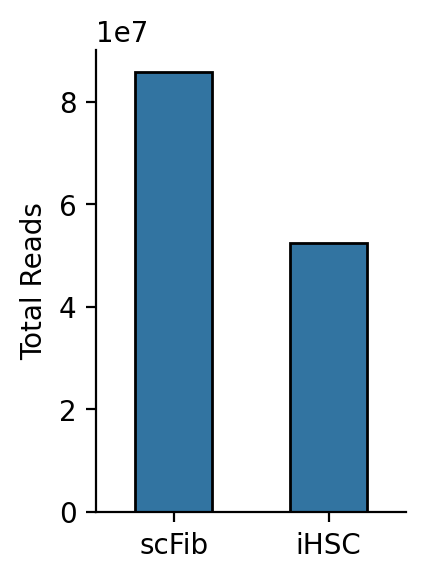

In [7]:
gx = df[['scFib', 'iHSC']].sum()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3

sns.barplot(
    gx,
    ec='k',
    width=0.5,
)

plt.ylabel("Total Reads")
sns.despine()

In [8]:
gx.sum()

138222390.0

In [9]:
# break

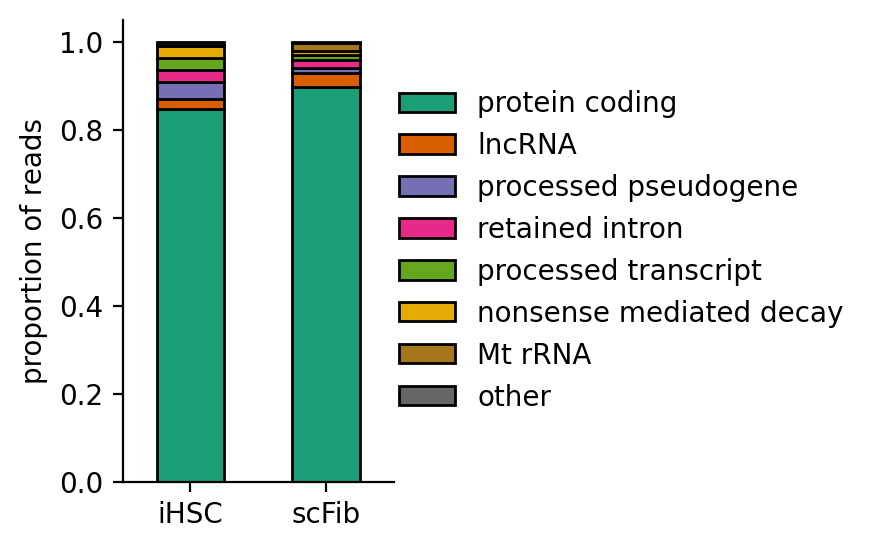

In [10]:
gx = df.groupby('transcript_biotype').agg(
    scFib=('scFib', 'sum'),
    iHSC=('iHSC', 'sum'),
)

# Calculate the total sum for each row
gx['total'] = gx['scFib'] + gx['iHSC']

# Calculate the percentage of each row relative to the total sum
gx['percentage'] = (gx['total'] / gx['total'].sum()) * 100

# Identify rows with less than 10%
other_rows = gx[gx['percentage'] < 1].index

# Aggregate 'other' rows
if len(other_rows) > 0:
    other_data = gx.loc[other_rows].sum()
    gx = gx.drop(other_rows)
    gx.loc['other'] = other_data

# Remove the 'total' and 'percentage' columns
gx = gx.drop(columns=['total', 'percentage'])

gx['scFib'] = gx['scFib'] / gx['scFib'].sum()
gx['iHSC'] = gx['iHSC'] / gx['iHSC'].sum()

gx.index = gx.index.map(lambda x: " ".join(x.split("_")))
gx = gx.loc[gx.sum(axis=1).sort_values(ascending=False).index]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.75, 3
gx.T.plot(
    kind='bar',
    stacked=True,
    cmap='Dark2',
    ec='k',
)

plt.gca().invert_xaxis()

plt.gca().tick_params(axis='x', rotation=0)
plt.ylabel("proportion of reads")
sns.despine()

sns.move_legend(
    plt.gca(),
    loc='center right',
    title="",
    frameon=False,
    bbox_to_anchor=(2.75, 0.5),
)

In [11]:
# break

Number of query genes in the 'Fibroblasts' pathway: 232
T-statistic: -1.948
P-value: 0.053
Not significant (p >= 0.05)


/tmp/ipykernel_1119404/1210069775.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Text(0, 0.5, 'isoforms per gene')

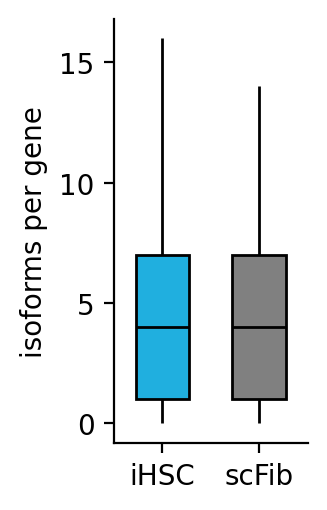

In [12]:
""" 
GENE SELECTION 
"""

fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)

print(f"Number of query genes in the '{pathway}' pathway: {len(query_genes)}")

pdf = df.copy()
pdf = pdf[pdf['gene_biotype'] == 'protein_coding']
pdf = pdf[pdf['gene_name'].isin(query_genes)]

gx = pdf.groupby('gene_name').agg(
    iHSC = ('iHSC', np.count_nonzero),
    scFib = ('scFib', np.count_nonzero),
)

"""
STATISTICAL TEST 
"""

# Perform the two-sided independent t-test
t_stat, p_value = ttest_rel(gx['iHSC'], gx['scFib'])

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Check significance at 0.05
alpha = 0.05
if p_value < alpha:
    print(f"Significant (p < {alpha})")
else:
    print(f"Not significant (p >= {alpha})")

"""
PLOT
"""
    
gx = gx.reset_index().melt(id_vars='gene_name')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.25, 2.75

sns.boxplot(
    data=gx,
    x='variable',
    y='value',
    width=0.55,
    showfliers=False,
    linecolor='k',
    showcaps=False,    # Remove caps
    palette=['#00BFFF', 'grey',]  
)

sns.despine()
plt.xlabel('')
plt.ylabel('isoforms per gene')

Text(0.5, 1.0, 'DAB2')

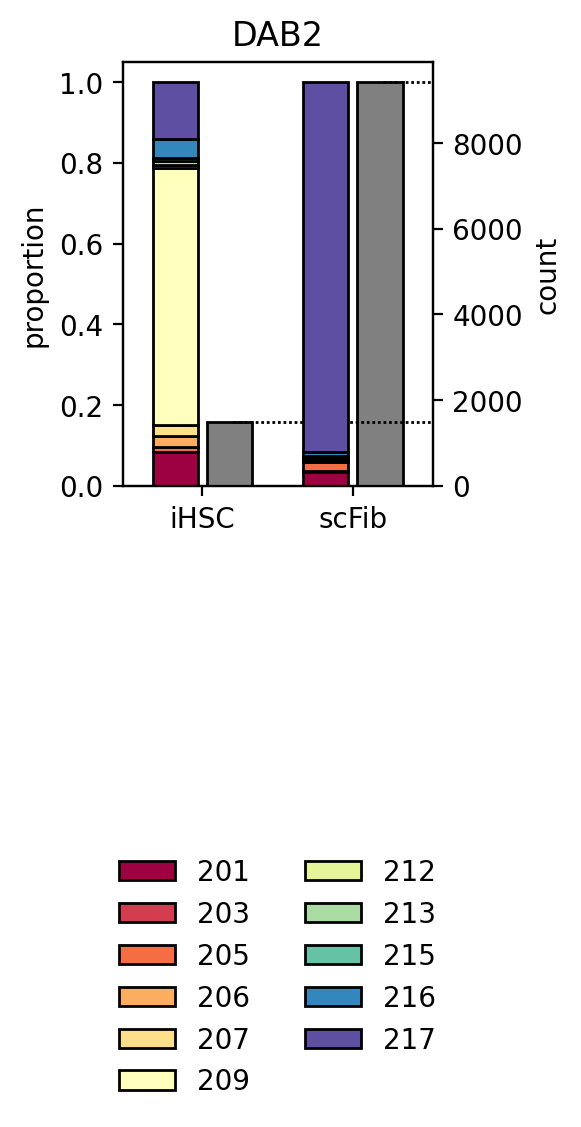

In [13]:
# query = 'PRRX1'
# query = 'CD34'
# query = 'GATA2'
query = 'DAB2'
width = 0.3
nudge = 0.03
color = 'grey'


"""
DATA SET UP
"""
pdf = df.copy()
pdf = pdf[pdf['gene_name'] == query]

pdf = pdf.sort_values(by='transcript_name')
pdf = pdf.set_index('transcript_name')

# get total counts for the gene
counts = pdf[['iHSC', 'scFib']].sum(axis=0)

# get transcript percentages
pdf = pdf[['iHSC_transcript_percent', 'scFib_transcript_percent']]
pdf = pdf[pdf.sum(axis=1) != 0] # drop zero-sum transcripts !

pdf.columns = pdf.columns.map(lambda x: x.split("_")[0])
pdf = pdf.T
pdf

"""
PLOT
"""
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.75
fig, ax1 = plt.subplots()

# Create a second axis for the count bar plot
ax2 = ax1.twinx()

ax2.bar(
    counts.index, 
    counts.values, 
    color=color, 
    ec='k',
    alpha=1,
    width=width,
    zorder=4,
    align='edge',
)

ax2.set_ylabel("count", color='k')
ax2.tick_params(axis='y', color='k', labelcolor='k')

# Add reference lines
for i, count in enumerate(counts.values):
    ax2.plot(
        [i + 0.2, 5], 
        [count, count], 
        color='k',
        linestyle='--',
        dashes=(1, 1),
        lw=1,
        zorder=5,
)

pdf.columns = [x.split("-")[1] for x in pdf.columns]
    
pdf.plot(
    kind='bar',
    stacked=True,
    ec='k',
    cmap='Spectral',
    width=-width,
    ax=ax1,
    zorder=2,
    align='edge',
)

ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.set_xlim([-.5 - nudge, 1.5 + nudge])

ax1.tick_params(axis='x', rotation=0)
ax1.set_ylabel(f"proportion")

# Shift bars to the left
bar_positions = [bar.get_x() for bar in ax1.patches]
new_positions = [pos - nudge for pos in bar_positions] 
for bar, new_pos in zip(ax1.patches, new_positions):
    bar.set_x(new_pos)
    
# Shift bars to the right
bar_positions = [bar.get_x() for bar in ax2.patches]
new_positions = [pos + nudge for pos in bar_positions] 
for bar, new_pos in zip(ax2.patches, new_positions):
    bar.set_x(new_pos)
        
sns.move_legend(
    ax1,
    loc='lower center',
    title="",
    frameon=False,
    bbox_to_anchor=(0.5, -1.5),
    ncol=2,
)

plt.title(query)

# Type switching

In [14]:
count_threshold = 500
prot_threshold = 1

pdf = df.copy()
"""
COUNT THRESHOLDING
"""
pdf = pdf[(pdf['iHSC_gene_count'] > count_threshold) \
          & (pdf['scFib_gene_count'] > count_threshold)]

"""
MUTLIPLE PROTEIN FILTER
"""
pdf = pdf[pdf.groupby('gene_name')['UniProtKB'].transform('nunique') >= prot_threshold]
pdf = pdf[pdf['UniProtKB'].notna()]


"""
DOMINANT ISOFORM IDENTIFICATION
"""
pdf['dom_iHSC_idx'] = pdf.groupby('gene_name')['iHSC_transcript_percent'].transform(pd.Series.idxmax)
pdf['dom_scFib_idx'] = pdf.groupby('gene_name')['scFib_transcript_percent'].transform(pd.Series.idxmax)

pdf = pdf[pdf['dom_iHSC_idx'] != pdf['dom_scFib_idx']]

print(f"Genes have a count greater than {count_threshold} in both datasets!")
print(f"Found {pdf['gene_name'].nunique()} genes with different dominant isoforms!")

"""
GENE ENTROPY COMPUTATION
"""
pdf['iHSC_entropy'] = pdf.groupby('gene_name')['iHSC_transcript_percent'].transform(entropy)
pdf['scFib_entropy'] = pdf.groupby('gene_name')['scFib_transcript_percent'].transform(entropy)
pdf['entropy_diff'] = (pdf['iHSC_entropy'] - pdf['scFib_entropy']).abs()

pdf = pdf.sort_values(by='entropy_diff', ascending=False)

pdf.head()

Genes have a count greater than 500 in both datasets!
Found 554 genes with different dominant isoforms!


,transcript_id,scFib,iHSC,Feature,gene_id,gene_name,gene_biotype,transcript_name,transcript_biotype,UniProtKB,...,iHSC_transcript_percent,scFib_transcript_percent,percent_diff,count_diff,norm_diff,dom_iHSC_idx,dom_scFib_idx,iHSC_entropy,scFib_entropy,entropy_diff
39391,ENST00000681967,1.0,0.0,transcript,ENSG00000144426,NBEAL1,protein_coding,NBEAL1-211,nonsense_mediated_decay,A0A804HIR8,...,0.000000,0.000019,-0.000019,-0.011649,-0.011649,39509,39475,0.185094,1.759056,1.573962
39539,ENST00000683338,0.0,0.0,transcript,ENSG00000144426,NBEAL1,protein_coding,NBEAL1-219,nonsense_mediated_decay,A0A804HHU0,...,0.000000,0.000000,0.000000,0.000000,0.000000,39509,39475,0.185094,1.759056,1.573962
25929,ENST00000414576,3.0,0.0,transcript,ENSG00000144426,NBEAL1,protein_coding,NBEAL1-201,protein_coding,H7BZA0,...,0.000000,0.000058,-0.000058,-0.034947,-0.034947,39509,39475,0.185094,1.759056,1.573962
39612,ENST00000683969,0.0,0.0,transcript,ENSG00000144426,NBEAL1,protein_coding,NBEAL1-222,protein_coding,A0A804HKS6,...,0.000000,0.000000,0.000000,0.000000,0.000000,39509,39475,0.185094,1.759056,1.573962
39509,ENST00000683091,6.0,322.0,transcript,ENSG00000144426,NBEAL1,protein_coding,NBEAL1-218,protein_coding,A0A804HI87,...,0.002721,0.000116,0.002605,321.930106,6.077779,39509,39475,0.185094,1.759056,1.573962


# Save the results

In [15]:
table = pdf.copy()
columns = [
    'gene_name',
    'transcript_name',
    'transcript_biotype',
    'UniProtKB',
    'scFib',
    'iHSC',
    'iHSC_transcript_percent',
    'scFib_transcript_percent',
    'iHSC_entropy',
    'scFib_entropy',
    'entropy_diff',
]

table = table[columns]
table = table.sort_values(by=['gene_name', 'transcript_name'])
print(f"{table.shape=}")
outpath = "../resources/isoform_shortlist.csv"
table.to_csv(outpath, index=False,)
table.head(10)

table.shape=(4669, 11)


,gene_name,transcript_name,transcript_biotype,UniProtKB,scFib,iHSC,iHSC_transcript_percent,scFib_transcript_percent,iHSC_entropy,scFib_entropy,entropy_diff
79596,ABCF1,ABCF1-201,protein_coding,Q8NE71,418.0,74.0,0.027196,0.069114,0.944408,0.541179,0.403229
82813,ABCF1,ABCF1-203,protein_coding,Q5STZ8,4862.0,651.0,0.239250,0.803902,0.944408,0.541179,0.403229
83831,ABCF1,ABCF1-204,protein_coding,F5GYK6,482.0,767.0,0.281882,0.079696,0.944408,0.541179,0.403229
84112,ABCF1,ABCF1-205,nonsense_mediated_decay,H0YGW7,0.0,36.0,0.013230,0.000000,0.944408,0.541179,0.403229
242628,ACOT9,ACOT9-201,protein_coding,Q9Y305,140.0,101.0,0.119104,0.076046,0.905904,1.006204,0.100300
246098,ACOT9,ACOT9-206,protein_coding,H7C5Q2,0.0,0.0,0.000000,0.000000,0.905904,1.006204,0.100300
246737,ACOT9,ACOT9-207,protein_coding,C9J7L8,45.0,17.0,0.020047,0.024443,0.905904,1.006204,0.100300
246809,ACOT9,ACOT9-208,nonsense_mediated_decay,F8WDI2,92.0,110.0,0.129717,0.049973,0.905904,1.006204,0.100300
23581,ACSL3,ACSL3-201,protein_coding,O95573,292.0,0.0,0.000000,0.155402,0.385830,0.835921,0.450092
24830,ACSL3,ACSL3-203,nonsense_mediated_decay,H7BYZ7,1.0,0.0,0.000000,0.000532,0.385830,0.835921,0.450092


Text(0.5, 0, 'iHSC (% GE)')

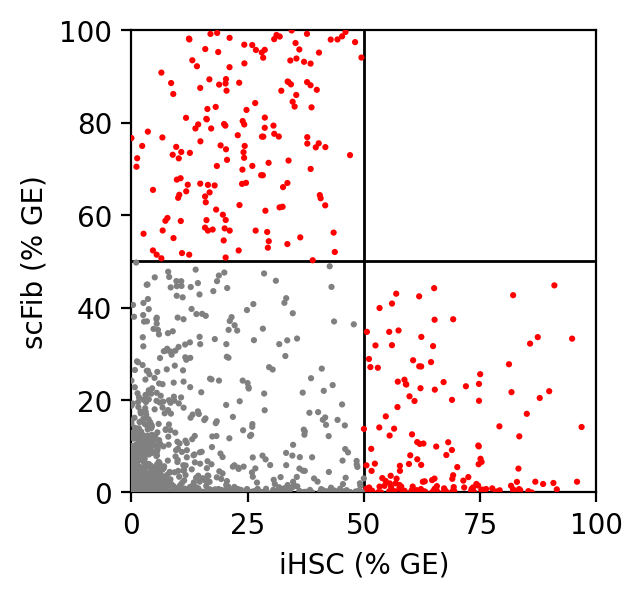

In [26]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

conditions = ((pdf['iHSC_transcript_percent'] < 0.5) ^ (pdf['scFib_transcript_percent'] > 0.5))

sns.scatterplot(
    data=pdf,
    x='iHSC_transcript_percent',
    y='scFib_transcript_percent',
    s=5,
    ec='none',
    hue=conditions,
    palette=['r','grey'],
    legend=False,
    zorder=3,
)

plt.axvline(x=0.5, c='k', lw=1, zorder=1)
plt.axhline(y=0.5, c='k', lw=1, zorder=1)

# Get the current x and y ticks
xticks = plt.xticks()[0]
yticks = plt.yticks()[0]

# Multiply the tick values by 100 and convert to integers for labels
new_xticklabels = [int(tick * 100) for tick in xticks]
new_yticklabels = [int(tick * 100) for tick in yticks]

# Set the new tick labels
plt.xticks(xticks, new_xticklabels)
plt.yticks(yticks, new_yticklabels)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel("scFib (% GE)")
plt.xlabel("iHSC (% GE)")

In [17]:
trx = pdf.copy()
trx = trx[(trx['iHSC_transcript_percent'] > 0.5) & (trx['scFib_transcript_percent'] < 0.5)]

fpath = "../resources/PanglaoDB_Augmented_2021.txt"
# fpath = "../resources/Tabula_Sapiens.txt"

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
# pathway = 'Blood-hematopoietic Stem Cell'
# pathway = 'Bone Marrow-hematopoietic Stem Cell'
features = ut.load_pathway(fpath)
query_genes = list(features[features[pathway]].index)

[x for x in trx['gene_name'].unique() if x in query_genes]

# trx.head()

['LOX', 'EFEMP1', 'SERPINH1', 'C1R']

In [18]:
[x for x in features.columns if 'hemato' in x.lower()]

['Hematopoietic Stem Cells']

In [19]:
n_genes = 25
trx = pdf.copy()
trx = trx[(trx['iHSC_transcript_percent'] < 0.5) & (trx['scFib_transcript_percent'] > 0.5)]
# trx = trx[(trx['iHSC_transcript_percent'] > 0.5) & (trx['scFib_transcript_percent'] < 0.5)]
trx = trx.sort_values(by='entropy_diff', ascending=False)
gene_list = trx['gene_name'].unique()
print(f"{len(gene_list)} genes meet the conditions.")

kdf = pdf.copy()
kdf = kdf[kdf['gene_name'].isin(gene_list[:n_genes])]
kdf = kdf[kdf[['scFib', 'iHSC']].sum(axis=1) > 0]
kdf = kdf[kdf.groupby('gene_name')['transcript_name'].transform('nunique') < 5]
print(f"{kdf.shape=}")

kdf = pd.melt(
    kdf, 
    id_vars=['gene_name', 'transcript_name'],
    value_vars=['iHSC_transcript_percent', 'scFib_transcript_percent'],
)

kdf = kdf.sort_values(by=['gene_name', 'transcript_name'])

kdf.head()


166 genes meet the conditions.
kdf.shape=(26, 24)


,gene_name,transcript_name,variable,value
21,GALNT1,GALNT1-201,iHSC_transcript_percent,0.398625
47,GALNT1,GALNT1-201,scFib_transcript_percent,0.871544
20,GALNT1,GALNT1-203,iHSC_transcript_percent,0.182818
46,GALNT1,GALNT1-203,scFib_transcript_percent,0.122120
22,GALNT1,GALNT1-204,iHSC_transcript_percent,0.413058


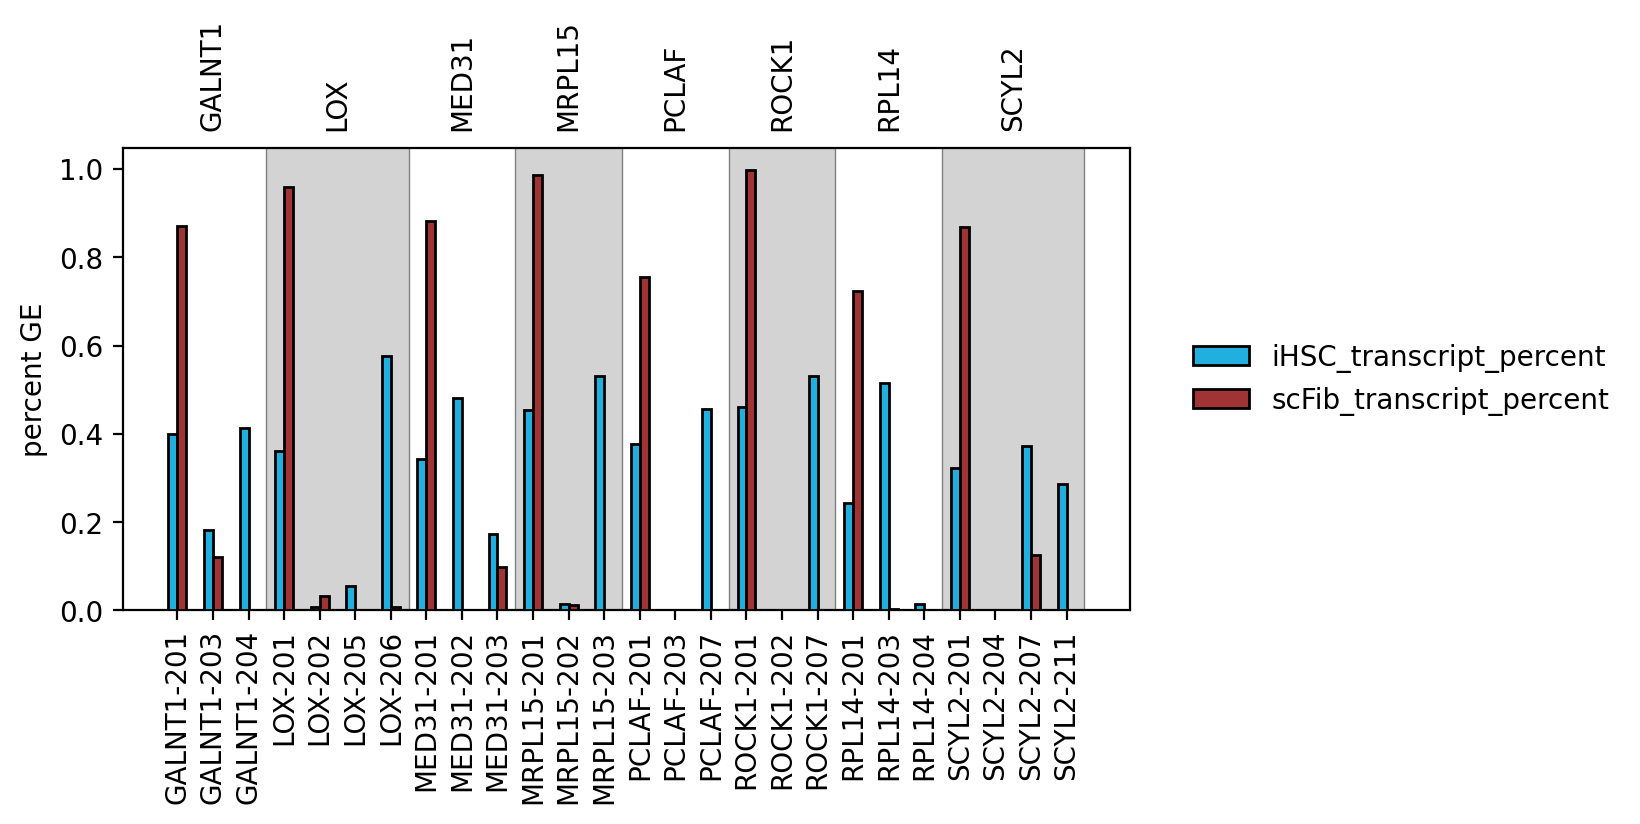

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = kdf.shape[0] / 8, 3


sns.barplot(
    data=kdf, 
    x='transcript_name',
    y='value',
    ec='k',
    hue='variable',
    palette=['deepskyblue', 'firebrick',],
    width=0.5,
    zorder=4,
)

ax = plt.gca()
ax.tick_params(axis='x', rotation=90)

plt.ylabel("percent GE")
plt.xlabel("")

# Extract xtick labels and positions
xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
xtick_positions = ax.get_xticks()

# Create a dictionary mapping labels to positions
xtick_dict = dict(zip(xtick_labels, xtick_positions))

for i, (gene, group) in enumerate(kdf.groupby('gene_name', sort=False)):

        
    start_item = group['transcript_name'].values[0]
    end_item = group['transcript_name'].values[-1]
    
    start = xtick_dict[start_item] - 0.5
    end = xtick_dict[end_item] + 0.5
    
    midpoint = ((end - start) / 2) + start
    
    ax.text(midpoint, 1.1, gene, rotation=90, ha='center')
        
    if i % 2 == 0:
        continue
    
    ax.axvline(x=start, lw=0.5, c='grey')
    ax.axvline(x=end, lw=0.5, c='grey')
    
    ax.axvspan(
        start, 
        end, 
        facecolor='lightgrey',
        zorder=1,
    )
        
sns.move_legend(
    ax,
    loc='center right',
    title="",
    frameon=False,
    bbox_to_anchor=(1.5, 0.5),
)

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Entropy distributions

In [ ]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
# fpath = "../resources/Tabula_Sapiens.txt"
features = ut.load_pathway(fpath)

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
# pathway = "Blood-hematopoietic Stem Cell"
# pathway = "Bone Marrow-hematopoietic Stem Cell"
# pathway = "Vasculature-fibroblast"
query_genes = list(features[features[pathway]].index)
print(len(query_genes))


kdf = pdf[pdf['gene_name'].isin(query_genes)]
kdf = kdf[['gene_name', 'iHSC_entropy', 'scFib_entropy']].drop_duplicates()
kdf = pd.melt(kdf, id_vars='gene_name')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = kdf.shape[0] / 4.5, 2.5

sns.barplot(
    data=kdf, 
    x='gene_name',
    y='value',
    hue='variable',
    ec='k',
    palette=['deepskyblue', 'firebrick',],
    width=0.5,
)

ax = plt.gca()
ax.tick_params(axis='x', rotation=90)
plt.ylabel('entropy')
plt.xlabel('')

sns.move_legend(
    ax,
    loc='center right',
    title="",
    frameon=False,
    bbox_to_anchor=(1.9, 0.5),
)


kdf.head()

In [ ]:
[x for x in features.columns if "fibro" in x.lower()]

In [ ]:
pdf.head()

In [ ]:
# n_genes = 100
# query = list(pdf['gene_name'].unique())[:n_genes]
# print(query)

# # database = 'ontology'
# # database = 'PanglaoDB_Augmented_2021'
# database = 'Tabula_Sapiens'

# edf = gget.enrichr(query, database=database)
# edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(25)

In [ ]:
# fpath = "../resources/PanglaoDB_Augmented_2021.txt"
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)


res = pdf[pdf['gene_name'].isin(query_genes)]
print(f"{res.shape=}")
res['gene_name'].unique()[:10]

In [ ]:
break

In [ ]:
pdf[pdf.groupby('gene_name')['UniProtKB'].transform('nunique') > 2]

In [ ]:
pdf[pdf['gene_name'] == 'ABI1']

In [ ]:
list(table.columns)

In [ ]:
break

In [ ]:
gdf[gdf['gene_name'] == 'RETSAT'].sort_values(by='transcript_name')

In [ ]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)

pdf = df.copy()
threshold = 100
pdf = pdf[pdf['gene_name'].isin(query_genes)]
pdf = pdf[(pdf['iHSC_gene_count'] > threshold) & (pdf['scFib_gene_count'] > threshold)]
pdf = pdf.sort_values(by='percent_diff', ascending=False)

columns = [
    'gene_name',
    'transcript_name',
    'transcript_biotype',
    'scFib',
    'iHSC',
    'iHSC_transcript_percent',
    'scFib_transcript_percent',
    'percent_diff',
]

pdf[columns].head(25)


In [ ]:
pdf = df.copy()
threshold = 100
pdf = pdf[(pdf['iHSC_gene_count'] > threshold) & (pdf['scFib_gene_count'] > threshold)]
pdf = pdf['']


pdf['n_trx_types'] = pdf.groupby('gene_name')['transcript_biotype'].transform('nunique')
pdf = pdf[pdf['n_trx_types'] > 1]

pdf['gene_norm_diff_mean'] = pdf.groupby('gene_name')['percent_diff'].transform('mean')
pdf = pdf.sort_values(by='gene_norm_diff_mean', ascending=False)

columns = [
    'gene_name',
    'transcript_name',
    'transcript_biotype',
    'scFib',
    'iHSC',
    'iHSC_transcript_percent',
    'scFib_transcript_percent',
    'percent_diff',
]

pdf[columns].head(25)

In [ ]:
list(pdf.columns)

In [ ]:
break

In [ ]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)


np.random.choice(query_genes, 10, replace=False)

In [ ]:
break